# Proyecto Etapa III: Implementación de Metaheurísticas para CVRP

## ISIS-3302 - Universidad de los Andes

Este notebook implementa un Algoritmo Genético (GA) para resolver el Capacitated Vehicle Routing Problem (CVRP) y compara los resultados con las soluciones obtenidas mediante Pyomo.

## 1. Importación de Librerías y Configuración

In [131]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
import time
import os
from copy import deepcopy
from collections import defaultdict
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

RANDOM_SEED = 42 # para que sean consistentes los resultados
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

## 2. Funciones Auxiliares para Lectura de Datos

In [132]:
def load_instance_data(case_number):
    """
    Carga los datos de una instancia específica según la estructura real del proyecto.
    """
    if case_number == 1:
        base_path = "./Proyecto_Caso_Base/"
    elif case_number == 2:
        base_path = "./Proyecto_A_Caso2/"
    elif case_number == 3:
        base_path = "./Proyecto_A_Caso3/"
    else:
        raise ValueError(f"Número de caso inválido: {case_number}")

    if not os.path.exists(base_path):
        print(f"Error: No se encontró la carpeta {base_path}")
        print("Estructura esperada:")
        print("  ./Proyecto_Caso_Base/")
        print("  ./Proyecto_A_Caso2/")
        print("  ./Proyecto_A_Caso3/")
        raise FileNotFoundError(f"No se encontró {base_path}")

    try:
        clients_df = pd.read_csv(os.path.join(base_path, "clients.csv"))
        depots_df = pd.read_csv(os.path.join(base_path, "depots.csv"))
        vehicles_df = pd.read_csv(os.path.join(base_path, "vehicles.csv"))

        print(f"\nDatos cargados exitosamente desde {base_path}")
        print(f"  - Clientes: {len(clients_df)}")
        print(f"  - Depósitos: {len(depots_df)}")
        print(f"  - Vehículos: {len(vehicles_df)}")

    except FileNotFoundError as e:
        print(f"Error: No se encontró el archivo {e.filename}")
        raise
    except Exception as e:
        print(f"Error al cargar archivos: {e}")
        raise

    depot_data = depots_df.iloc[0]

    required_client_cols = ['ClientID', 'Demand', 'Latitude', 'Longitude']
    required_depot_cols = ['DepotID', 'Latitude', 'Longitude']
    required_vehicle_cols = ['VehicleID', 'Capacity']

    missing_client_cols = set(required_client_cols) - set(clients_df.columns)
    if missing_client_cols:
        print(
            f"Advertencia: Faltan columnas en clients.csv: {missing_client_cols}")

    missing_vehicle_cols = set(required_vehicle_cols) - \
        set(vehicles_df.columns)
    if missing_vehicle_cols:
        print(
            f"Advertencia: Faltan columnas en vehicles.csv: {missing_vehicle_cols}")

    return {
        'clients': clients_df,
        'depot': depot_data,
        'vehicles': vehicles_df,
        'num_clients': len(clients_df),
        'num_vehicles': len(vehicles_df),
        'depot_id': int(depot_data['DepotID']),
        'case_number': case_number
    }


def calculate_distance_matrix(instance_data):
    """
    Calcula la matriz de distancias euclidianas.
    """
    clients = instance_data['clients']
    depot = instance_data['depot']

    n_nodes = len(clients) + 1

    dist_matrix = np.zeros((n_nodes, n_nodes))

    depot_coords = (depot['Latitude'], depot['Longitude'])

    for i, client in clients.iterrows():
        client_coords = (client['Latitude'], client['Longitude'])
        # Distancia euclidiana (aproximación)
        dist = np.sqrt((depot_coords[0] - client_coords[0])**2 +
                       # Aprox km
                       (depot_coords[1] - client_coords[1])**2) * 111
        dist_matrix[0][i+1] = dist
        dist_matrix[i+1][0] = dist

    for i, client1 in clients.iterrows():
        for j, client2 in clients.iterrows():
            if i != j:
                coords1 = (client1['Latitude'], client1['Longitude'])
                coords2 = (client2['Latitude'], client2['Longitude'])
                dist = np.sqrt((coords1[0] - coords2[0])**2 +
                               (coords1[1] - coords2[1])**2) * 111
                dist_matrix[i+1][j+1] = dist

    return dist_matrix


def verify_data_structure():
    """
    Verifica que todos los archivos necesarios existan y tengan la estructura correcta.
    """
    cases = {
        1: "./Proyecto_Caso_Base/",
        2: "./Proyecto_A_Caso2/",
        3: "./Proyecto_A_Caso3/"
    }

    print("Verificando estructura de archivos...")
    print("="*50)

    all_ok = True

    for case_num, path in cases.items():
        print(f"\nCaso {case_num}: {path}")

        if not os.path.exists(path):
            print(f"Carpeta no encontrada")
            all_ok = False
            continue
        else:
            print(f"Carpeta encontrada")

        required_files = ['clients.csv', 'depots.csv', 'vehicles.csv']
        for file in required_files:
            file_path = os.path.join(path, file)
            if os.path.exists(file_path):
                # Intentar leer el archivo
                try:
                    df = pd.read_csv(file_path)
                    print(f"    ✓ {file} - {len(df)} registros")
                except Exception as e:
                    print(f" {file} - Error al leer: {e}")
                    all_ok = False
            else:
                print(f" {file} - No encontrado")
                all_ok = False

    if all_ok:
        print("\n Todos los archivos están en orden")
    else:
        print("\n Hay problemas con algunos archivos")

    return all_ok

## 3. Implementación del Algoritmo Genético para CVRP

In [133]:
# Funciones auxiliares para manejar casos pequeños como el Caso 2
def patch_genetic_algorithm_for_small_instances():
    """
    Devuelve versiones parcheadas de los métodos del GA para casos pequeños.
    """

    def safe_route_based_crossover(self, parent1, parent2):
        """Crossover seguro para casos con pocas rutas."""
        if random.random() > self.crossover_rate:
            return deepcopy(parent1), deepcopy(parent2)

        child1 = deepcopy(parent1)
        child2 = deepcopy(parent2)

        # Si alguno tiene solo 1 ruta, usar crossover diferente
        if len(child1) <= 1 or len(child2) <= 1:
            # Extraer todos los clientes
            all_clients1 = [c for route in parent1 for c in route]
            all_clients2 = [c for route in parent2 for c in route]

            # Si hay muy pocos clientes, solo intercambiar orden
            if len(all_clients1) <= 3:
                return deepcopy(parent2), deepcopy(parent1)

            # Order crossover
            size = len(all_clients1)
            start = random.randint(0, size - 2)
            end = random.randint(start + 1, size)

            # Crear hijos
            child1_clients = all_clients1[start:end]
            child2_clients = all_clients2[start:end]

            # Completar con clientes del otro padre
            for c in all_clients2:
                if c not in child1_clients:
                    child1_clients.append(c)

            for c in all_clients1:
                if c not in child2_clients:
                    child2_clients.append(c)

            # Reconstruir rutas respetando capacidad
            def rebuild_routes(client_list):
                routes = []
                current_route = []
                current_load = 0

                for client in client_list:
                    if current_load + self.demands[client] <= self.vehicle_capacity:
                        current_route.append(client)
                        current_load += self.demands[client]
                    else:
                        if current_route:
                            routes.append(current_route)
                        current_route = [client]
                        current_load = self.demands[client]

                if current_route:
                    routes.append(current_route)

                return routes

            return rebuild_routes(child1_clients), rebuild_routes(child2_clients)

        # Si hay al menos 2 rutas, intercambiar máximo 1
        num_routes_to_swap = 1

        if child1 and child2:
            idx1 = random.randint(0, len(child1) - 1)
            idx2 = random.randint(0, len(child2) - 1)
            child1[idx1], child2[idx2] = child2[idx2], child1[idx1]

        # Reparar las soluciones
        child1 = self.repair_solution(child1)
        child2 = self.repair_solution(child2)

        return child1, child2

    def safe_mutate(self, solution):
        """Mutación segura para casos con pocas rutas."""
        if random.random() > self.mutation_rate:
            return solution

        mutated = deepcopy(solution)

        # Si solo hay una ruta, solo podemos hacer 2-opt o inversión
        if len(mutated) == 1:
            if len(mutated[0]) >= 3:
                # Aplicar 2-opt
                mutated[0] = self.two_opt(mutated[0], max_iterations=20)
            elif len(mutated[0]) == 2:
                # Solo invertir
                mutated[0] = mutated[0][::-1]
            return mutated

        # Para 2 o más rutas, usar mutaciones limitadas
        mutation_types = ['2opt', 'swap_within', 'relocate']
        mutation_type = random.choice(mutation_types)

        if mutation_type == '2opt':
            # Aplicar 2-opt a una ruta aleatoria
            route_idx = random.randint(0, len(mutated) - 1)
            if len(mutated[route_idx]) >= 3:
                mutated[route_idx] = self.two_opt(
                    mutated[route_idx], max_iterations=10)

        elif mutation_type == 'swap_within' and len(mutated) >= 1:
            # Intercambiar dos clientes dentro de la misma ruta
            route_idx = random.randint(0, len(mutated) - 1)
            if len(mutated[route_idx]) >= 2:
                i = random.randint(0, len(mutated[route_idx]) - 1)
                j = random.randint(0, len(mutated[route_idx]) - 1)
                mutated[route_idx][i], mutated[route_idx][j] = mutated[route_idx][j], mutated[route_idx][i]

        elif mutation_type == 'relocate' and len(mutated) >= 2:
            # Intentar mover un cliente entre rutas
            from_idx = random.randint(0, len(mutated) - 1)
            to_idx = random.randint(0, len(mutated) - 1)

            if from_idx != to_idx and len(mutated[from_idx]) > 1:
                # Verificar capacidad
                client_idx = random.randint(0, len(mutated[from_idx]) - 1)
                client = mutated[from_idx][client_idx]

                to_load = sum(self.demands[c] for c in mutated[to_idx])
                if to_load + self.demands[client] <= self.vehicle_capacity:
                    mutated[from_idx].pop(client_idx)
                    mutated[to_idx].append(client)

        # Limpiar rutas vacías
        mutated = [route for route in mutated if route]

        # Si quedó vacío, devolver la solución original
        if not mutated:
            return solution

        return mutated

    def safe_select_parents(self):
        """Selección segura para poblaciones pequeñas."""
        # Ajustar tamaño del torneo
        actual_tournament_size = min(
            self.tournament_size, len(self.population), 3)

        def tournament():
            if len(self.population) <= actual_tournament_size:
                participants = list(range(len(self.population)))
            else:
                participants = random.sample(
                    range(len(self.population)), actual_tournament_size)

            participants_fitness = [(p, self.evaluate_fitness(self.population[p]))
                                    for p in participants]
            winner = min(participants_fitness, key=lambda x: x[1])[0]
            return self.population[winner]

        parent1 = tournament()
        parent2 = tournament()

        # Asegurar que sean diferentes si es posible
        if len(self.population) > 1 and parent1 is parent2:
            parent2 = tournament()

        return parent1, parent2

    return safe_route_based_crossover, safe_mutate, safe_select_parents

class GeneticAlgorithmCVRP:
    """
    Algoritmo Genético para el Capacitated Vehicle Routing Problem (CVRP).
    
    Esta implementación está diseñada específicamente para el CVRP con:
    - Un único depósito
    - Flota homogénea de vehículos
    - Restricciones de capacidad
    """
    
    def __init__(self, instance_data, dist_matrix, population_size=100, 
                 generations=500, mutation_rate=0.2, crossover_rate=0.8, 
                 elitism_rate=0.1, tournament_size=5):
        """
        Inicializa el algoritmo genético.
        """
        self.instance_data = instance_data
        self.dist_matrix = dist_matrix
        self.num_clients = instance_data['num_clients']
        self.num_vehicles = instance_data['num_vehicles']
        
        # Extraer demandas y capacidad del vehículo
        self.demands = [0] + list(instance_data['clients']['Demand'])  # 0 para el depot
        self.vehicle_capacity = instance_data['vehicles']['Capacity'].iloc[0]
        
        # Parámetros del GA
        self.population_size = population_size
        self.generations = generations
        self.mutation_rate = mutation_rate
        self.crossover_rate = crossover_rate
        self.elitism_rate = elitism_rate
        self.tournament_size = tournament_size
        
        # Resultados
        self.best_solution = None
        self.best_fitness = float('inf')
        self.fitness_history = []
        self.population = []
        
    def create_initial_solution(self):
        """
        Crea una solución inicial usando la heurística del vecino más cercano con capacidad.
        """
        unvisited = list(range(1, self.num_clients + 1))
        routes = []
        
        while unvisited:
            route = []
            current_capacity = 0
            current_node = 0  # Empezar desde el depot
            
            while unvisited:
                # Encontrar el cliente más cercano que quepa en el vehículo
                best_client = None
                best_distance = float('inf')
                
                for client in unvisited:
                    if current_capacity + self.demands[client] <= self.vehicle_capacity:
                        dist = self.dist_matrix[current_node][client]
                        if dist < best_distance:
                            best_distance = dist
                            best_client = client
                
                if best_client is None:
                    break  # No hay más clientes que quepan
                
                # Agregar el cliente a la ruta
                route.append(best_client)
                unvisited.remove(best_client)
                current_capacity += self.demands[best_client]
                current_node = best_client
            
            if route:
                routes.append(route)
        
        return routes
    
    def create_random_solution(self):
        """
        Crea una solución aleatoria válida.
        """
        # Permutar aleatoriamente los clientes
        clients = list(range(1, self.num_clients + 1))
        random.shuffle(clients)
        
        # Dividir en rutas respetando la capacidad
        routes = []
        current_route = []
        current_capacity = 0
        
        for client in clients:
            if current_capacity + self.demands[client] <= self.vehicle_capacity:
                current_route.append(client)
                current_capacity += self.demands[client]
            else:
                if current_route:
                    routes.append(current_route)
                current_route = [client]
                current_capacity = self.demands[client]
        
        if current_route:
            routes.append(current_route)
        
        # Aplicar 2-opt a cada ruta
        for i in range(len(routes)):
            if len(routes[i]) > 2:
                routes[i] = self.two_opt(routes[i])
        
        return routes
    
    def two_opt(self, route, max_iterations=50):
        """
        Mejora una ruta usando 2-opt.
        """
        if len(route) < 3:
            return route
        
        best_route = route.copy()
        best_cost = self.calculate_route_cost(best_route)
        improved = True
        iterations = 0
        
        while improved and iterations < max_iterations:
            improved = False
            iterations += 1
            
            for i in range(len(route) - 1):
                for j in range(i + 2, len(route)):
                    # Intercambiar segmento
                    new_route = best_route[:i+1] + best_route[i+1:j+1][::-1] + best_route[j+1:]
                    new_cost = self.calculate_route_cost(new_route)
                    
                    if new_cost < best_cost:
                        best_route = new_route
                        best_cost = new_cost
                        improved = True
        
        return best_route
    
    def calculate_route_cost(self, route):
        """
        Calcula el costo (distancia) de una ruta.
        """
        if not route:
            return 0
        
        cost = self.dist_matrix[0][route[0]]  # Del depot al primer cliente
        for i in range(len(route) - 1):
            cost += self.dist_matrix[route[i]][route[i+1]]
        cost += self.dist_matrix[route[-1]][0]  # Del último cliente al depot
        
        return cost
    
    def evaluate_fitness(self, solution):
        """
        Evalúa la fitness (costo total) de una solución.
        """
        total_cost = 0
        for route in solution:
            total_cost += self.calculate_route_cost(route)
        return total_cost
    
    def initialize_population(self):
        """
        Inicializa la población con soluciones diversas.
        """
        population = []
        
        # Agregar algunas soluciones construidas con heurísticas
        for _ in range(self.population_size // 4):
            population.append(self.create_initial_solution())
        
        # El resto son soluciones aleatorias
        while len(population) < self.population_size:
            population.append(self.create_random_solution())
        
        self.population = population
    
    def select_parents(self):
        """
        Selección por torneo.
        """
        def tournament():
            participants = random.sample(range(len(self.population)), self.tournament_size)
            participants_fitness = [(p, self.evaluate_fitness(self.population[p])) 
                                  for p in participants]
            winner = min(participants_fitness, key=lambda x: x[1])[0]
            return self.population[winner]
        
        return tournament(), tournament()
    
    def route_based_crossover(self, parent1, parent2):
        """
        Crossover basado en intercambio de rutas.
        """
        if random.random() > self.crossover_rate:
            return deepcopy(parent1), deepcopy(parent2)
        
        child1 = deepcopy(parent1)
        child2 = deepcopy(parent2)
        
        # Intercambiar algunas rutas completas
        num_routes_to_swap = random.randint(1, min(len(child1), len(child2)) // 2)
        
        for _ in range(num_routes_to_swap):
            if child1 and child2:
                idx1 = random.randint(0, len(child1) - 1)
                idx2 = random.randint(0, len(child2) - 1)
                child1[idx1], child2[idx2] = child2[idx2], child1[idx1]
        
        # Reparar las soluciones
        child1 = self.repair_solution(child1)
        child2 = self.repair_solution(child2)
        
        return child1, child2
    
    def repair_solution(self, solution):
        """
        Repara una solución eliminando duplicados y agregando clientes faltantes.
        """
        # Obtener todos los clientes en la solución
        visited = set()
        for route in solution:
            visited.update(route)
        
        # Eliminar duplicados
        new_solution = []
        seen = set()
        
        for route in solution:
            new_route = []
            for client in route:
                if client not in seen:
                    new_route.append(client)
                    seen.add(client)
            if new_route:
                new_solution.append(new_route)
        
        # Agregar clientes faltantes
        missing = set(range(1, self.num_clients + 1)) - seen
        
        for client in missing:
            # Intentar agregar a una ruta existente
            added = False
            for route in new_solution:
                route_demand = sum(self.demands[c] for c in route)
                if route_demand + self.demands[client] <= self.vehicle_capacity:
                    # Encontrar la mejor posición
                    best_pos = 0
                    best_cost = float('inf')
                    
                    for pos in range(len(route) + 1):
                        test_route = route[:pos] + [client] + route[pos:]
                        cost = self.calculate_route_cost(test_route)
                        if cost < best_cost:
                            best_cost = cost
                            best_pos = pos
                    
                    route.insert(best_pos, client)
                    added = True
                    break
            
            # Si no se pudo agregar, crear nueva ruta
            if not added:
                new_solution.append([client])
        
        return new_solution
    
    def mutate(self, solution):
        """
        Aplica mutación a una solución.
        """
        if random.random() > self.mutation_rate:
            return solution
        
        mutated = deepcopy(solution)
        mutation_type = random.choice(['swap', 'relocate', 'invert', '2opt'])
        
        if mutation_type == 'swap':
            # Intercambiar dos clientes
            if len(mutated) >= 2:
                route1_idx = random.randint(0, len(mutated) - 1)
                route2_idx = random.randint(0, len(mutated) - 1)
                
                if mutated[route1_idx] and mutated[route2_idx]:
                    pos1 = random.randint(0, len(mutated[route1_idx]) - 1)
                    pos2 = random.randint(0, len(mutated[route2_idx]) - 1)
                    
                    # Verificar capacidad
                    client1 = mutated[route1_idx][pos1]
                    client2 = mutated[route2_idx][pos2]
                    
                    route1_demand = sum(self.demands[c] for c in mutated[route1_idx]) - self.demands[client1] + self.demands[client2]
                    route2_demand = sum(self.demands[c] for c in mutated[route2_idx]) - self.demands[client2] + self.demands[client1]
                    
                    if (route1_demand <= self.vehicle_capacity and 
                        route2_demand <= self.vehicle_capacity):
                        mutated[route1_idx][pos1], mutated[route2_idx][pos2] = \
                            mutated[route2_idx][pos2], mutated[route1_idx][pos1]
        
        elif mutation_type == 'relocate':
            # Reubicar un cliente
            if mutated:
                from_route_idx = random.randint(0, len(mutated) - 1)
                if mutated[from_route_idx] and len(mutated[from_route_idx]) > 1:
                    client_pos = random.randint(0, len(mutated[from_route_idx]) - 1)
                    client = mutated[from_route_idx].pop(client_pos)
                    
                    # Intentar insertar en otra ruta
                    best_route_idx = from_route_idx
                    best_pos = client_pos
                    best_cost_increase = float('inf')
                    
                    for route_idx in range(len(mutated)):
                        route_demand = sum(self.demands[c] for c in mutated[route_idx])
                        if route_demand + self.demands[client] <= self.vehicle_capacity:
                            for pos in range(len(mutated[route_idx]) + 1):
                                # Calcular el incremento en costo
                                if pos == 0:
                                    if mutated[route_idx]:
                                        cost_increase = (self.dist_matrix[0][client] + 
                                                       self.dist_matrix[client][mutated[route_idx][0]] - 
                                                       self.dist_matrix[0][mutated[route_idx][0]])
                                    else:
                                        cost_increase = 2 * self.dist_matrix[0][client]
                                elif pos == len(mutated[route_idx]):
                                    cost_increase = (self.dist_matrix[mutated[route_idx][-1]][client] + 
                                                   self.dist_matrix[client][0] - 
                                                   self.dist_matrix[mutated[route_idx][-1]][0])
                                else:
                                    cost_increase = (self.dist_matrix[mutated[route_idx][pos-1]][client] + 
                                                   self.dist_matrix[client][mutated[route_idx][pos]] - 
                                                   self.dist_matrix[mutated[route_idx][pos-1]][mutated[route_idx][pos]])
                                
                                if cost_increase < best_cost_increase:
                                    best_cost_increase = cost_increase
                                    best_route_idx = route_idx
                                    best_pos = pos
                    
                    mutated[best_route_idx].insert(best_pos, client)
        
        elif mutation_type == 'invert':
            if mutated:
                route_idx = random.randint(0, len(mutated) - 1)
                if len(mutated[route_idx]) >= 3:
                    start = random.randint(0, len(mutated[route_idx]) - 2)
                    end = random.randint(start + 1, len(mutated[route_idx]) - 1)
                    mutated[route_idx][start:end+1] = mutated[route_idx][start:end+1][::-1]
        
        else: 
            if mutated:
                route_idx = random.randint(0, len(mutated) - 1)
                if len(mutated[route_idx]) > 2:
                    mutated[route_idx] = self.two_opt(mutated[route_idx], max_iterations=10)
        
        mutated = [route for route in mutated if route]
        
        return mutated
    
    def evolve_population(self):
        """
        Evoluciona la población a la siguiente generación.
        """
        # Evaluar población actual
        population_fitness = [(i, self.evaluate_fitness(solution)) 
                            for i, solution in enumerate(self.population)]
        population_fitness.sort(key=lambda x: x[1])
        
        # Elitismo
        num_elite = max(1, int(self.elitism_rate * self.population_size))
        elite_indices = [idx for idx, _ in population_fitness[:num_elite]]
        new_population = [deepcopy(self.population[idx]) for idx in elite_indices]
        
        # Generar descendencia
        while len(new_population) < self.population_size:
            parent1, parent2 = self.select_parents()
            child1, child2 = self.route_based_crossover(parent1, parent2)
            child1 = self.mutate(child1)
            child2 = self.mutate(child2)
            
            new_population.append(child1)
            if len(new_population) < self.population_size:
                new_population.append(child2)
        
        self.population = new_population
    
    def solve(self, verbose=True, early_stopping_generations=50):
        """
        Ejecuta el algoritmo genético.
        """
        # Inicializar población
        self.initialize_population()
        
        # Variables para tracking
        best_solution = None
        best_fitness = float('inf')
        generations_without_improvement = 0
        start_time = time.time()
        
        # Evolución
        for generation in range(self.generations):
            self.evolve_population()
            
            # Encontrar mejor solución de la generación
            current_best = None
            current_best_fitness = float('inf')
            
            for solution in self.population:
                fitness = self.evaluate_fitness(solution)
                if fitness < current_best_fitness:
                    current_best = solution
                    current_best_fitness = fitness
            
            # Actualizar mejor global
            if current_best_fitness < best_fitness:
                best_solution = deepcopy(current_best)
                best_fitness = current_best_fitness
                generations_without_improvement = 0
            else:
                generations_without_improvement += 1
            
            self.fitness_history.append(current_best_fitness)
            
            # Imprimir progreso
            if verbose and generation % 50 == 0:
                elapsed_time = time.time() - start_time
                print(f"Generación {generation}: Mejor fitness = {best_fitness:.2f}, "
                      f"Tiempo = {elapsed_time:.2f}s")
            
            # Early stopping
            if generations_without_improvement >= early_stopping_generations:
                if verbose:
                    print(f"\nEarly stopping en generación {generation}")
                break
        
        self.best_solution = best_solution
        self.best_fitness = best_fitness
        
        total_time = time.time() - start_time
        
        if verbose:
            print(f"\nOptimización completada:")
            print(f"  Mejor fitness: {best_fitness:.2f}")
            print(f"  Tiempo total: {total_time:.2f}s")
            print(f"  Número de rutas: {len(best_solution)}")
        
        return best_solution, best_fitness, total_time
    
    def get_solution_details(self):
        """
        Obtiene detalles de la mejor solución.
        """
        if not self.best_solution:
            return None
        
        details = {
            'total_cost': self.best_fitness,
            'num_routes': len(self.best_solution),
            'routes': [],
            'vehicle_loads': [],
            'vehicle_distances': []
        }
        
        for i, route in enumerate(self.best_solution):
            route_cost = self.calculate_route_cost(route)
            route_load = sum(self.demands[client] for client in route)
            
            details['routes'].append({
                'vehicle': i + 1,
                'sequence': [0] + route + [0],  # Incluir depot
                'cost': route_cost,
                'load': route_load,
                'capacity_utilization': (route_load / self.vehicle_capacity) * 100
            })
            
            details['vehicle_loads'].append(route_load)
            details['vehicle_distances'].append(route_cost)
        
        return details

# Tuvimos problemas con el caso 2 entonces tocó crear esta función para que corra el caso 2

def create_ga_for_small_instance(instance_data, dist_matrix, params):
    """
    Crea un GA especialmente configurado para instancias pequeñas.
    """
    # Ajustar parámetros para instancias pequeñas
    adjusted_params = params.copy()
    adjusted_params['population_size'] = min(
        50, params.get('population_size', 100))
    adjusted_params['tournament_size'] = 3

    # Crear GA
    ga = GeneticAlgorithmCVRP(
        instance_data=instance_data,
        dist_matrix=dist_matrix,
        **adjusted_params
    )

    # Obtener métodos parcheados
    safe_crossover, safe_mutate, safe_select = patch_genetic_algorithm_for_small_instances()

    # Aplicar parches
    ga.route_based_crossover = safe_crossover.__get__(ga, GeneticAlgorithmCVRP)
    ga.mutate = safe_mutate.__get__(ga, GeneticAlgorithmCVRP)
    ga.select_parents = safe_select.__get__(ga, GeneticAlgorithmCVRP)

    original_create_random = ga.create_random_solution

    def create_random_solution_small():
        """Crea solución aleatoria para casos pequeños."""
        # Si la demanda total es muy baja, intentar con 1-2 rutas
        total_demand = sum(ga.demands[1:])  # Excluir depot

        if total_demand <= ga.vehicle_capacity:
            # Todo cabe en un vehículo
            return [list(range(1, ga.num_clients + 1))]

        # Crear solución con distribución más uniforme
        clients = list(range(1, ga.num_clients + 1))
        random.shuffle(clients)

        # Intentar distribuir equitativamente
        num_vehicles = max(2, int(np.ceil(total_demand / ga.vehicle_capacity)))
        routes = [[] for _ in range(num_vehicles)]
        loads = [0] * num_vehicles

        for client in clients:
            best_route = None
            min_load = float('inf')

            for i in range(num_vehicles):
                if loads[i] + ga.demands[client] <= ga.vehicle_capacity and loads[i] < min_load:
                    best_route = i
                    min_load = loads[i]

            if best_route is not None:
                routes[best_route].append(client)
                loads[best_route] += ga.demands[client]
            else:
                routes.append([client])
                loads.append(ga.demands[client])

        routes = [route for route in routes if route]
        for i in range(len(routes)):
            if len(routes[i]) > 2:
                routes[i] = ga.two_opt(routes[i])

        return routes

    ga.create_random_solution = create_random_solution_small

    return ga

## 5. Calibración de Parámetros del GA

In [134]:
def parameter_tuning(instance_data, dist_matrix, param_grid, n_runs=3):
    """
    Realiza la calibración de parámetros del GA.
    """
    results = []
    
    for params in param_grid:
        print(f"\nProbando configuración: {params}")
        
        costs = []
        times = []
        
        for run in range(n_runs):
            random.seed(RANDOM_SEED + run)
            np.random.seed(RANDOM_SEED + run)
            
            ga = GeneticAlgorithmCVRP(
                instance_data=instance_data,
                dist_matrix=dist_matrix,
                **params
            )
            
            _, cost, exec_time = ga.solve(verbose=False, early_stopping_generations=30)
            costs.append(cost)
            times.append(exec_time)
        
        avg_cost = np.mean(costs)
        std_cost = np.std(costs)
        avg_time = np.mean(times)
        
        results.append({
            'params': params,
            'avg_cost': avg_cost,
            'std_cost': std_cost,
            'avg_time': avg_time,
            'costs': costs
        })
        
        print(f"  Costo promedio: {avg_cost:.2f} ± {std_cost:.2f}")
        print(f"  Tiempo promedio: {avg_time:.2f}s")
    
    results.sort(key=lambda x: x['avg_cost'])
    
    return results

param_grid = [
    {
        'population_size': 100,
        'generations': 300,
        'mutation_rate': 0.1,
        'crossover_rate': 0.9,
        'elitism_rate': 0.1
    },
    {
        'population_size': 150,
        'generations': 300,
        'mutation_rate': 0.2,
        'crossover_rate': 0.8,
        'elitism_rate': 0.15
    },
    {
        'population_size': 200,
        'generations': 300,
        'mutation_rate': 0.3,
        'crossover_rate': 0.7,
        'elitism_rate': 0.2
    }
]

## 6. Ejecución de Experimentos

In [135]:
# 6. Ejecución de Experimentos

# Primero verificamos que todo esté en orden
print("VERIFICACIÓN INICIAL DE ARCHIVOS")
print("="*60)
verify_data_structure()

# Variables para guardar todo
all_results = {}
actual_data_info = {}  # info de cada caso

# Correr los 3 casos
for case_number in [1, 2, 3]:
    print(f"\n{'='*60}")
    print(f"PROCESANDO CASO {case_number}")
    print(f"{'='*60}")

    try:
        # Cargar datos
        instance_data = load_instance_data(case_number)
        dist_matrix = calculate_distance_matrix(instance_data)

        # guardar info importante
        actual_data_info[case_number] = {
            'num_clients': instance_data['num_clients'],
            'num_vehicles': instance_data['num_vehicles'],
            'vehicle_capacity': instance_data['vehicles']['Capacity'].iloc[0]
        }

        print(f"\nInstancia cargada correctamente:")
        print(f"  Número de clientes: {instance_data['num_clients']}")
        print(f"  Número de vehículos: {instance_data['num_vehicles']}")
        print(
            f"  Capacidad del vehículo: {instance_data['vehicles']['Capacity'].iloc[0]}")

        # Ver si es factible
        total_demand = instance_data['clients']['Demand'].sum()
        vehicle_capacity = instance_data['vehicles']['Capacity'].iloc[0]
        min_vehicles_needed = np.ceil(total_demand / vehicle_capacity)

        print(f"\nAnálisis de factibilidad:")
        print(f"  Demanda total: {total_demand}")
        print(f"  Vehículos mínimos necesarios: {int(min_vehicles_needed)}")

        if total_demand <= vehicle_capacity:
            print("  ⚠️ Todos los clientes caben en un solo vehículo")

    except Exception as e:
        print(f"\nError al cargar datos del Caso {case_number}: {e}")
        continue

    # Solo calibrar params en el primer caso
    if case_number == 1:
        print("\nRealizando calibración de parámetros...")

        # Probamos 2 configs nada más
        param_grid = [
            {
                'population_size': 100,
                'generations': 300,
                'mutation_rate': 0.15,
                'crossover_rate': 0.85,
                'elitism_rate': 0.1
            },
            {
                'population_size': 150,
                'generations': 300,
                'mutation_rate': 0.2,
                'crossover_rate': 0.8,
                'elitism_rate': 0.15
            }
        ]

        tuning_results = parameter_tuning(
            instance_data, dist_matrix, param_grid, n_runs=2)
        best_params = tuning_results[0]['params']
        print(f"\nMejores parámetros encontrados: {best_params}")
    else:
        # reusar los params del caso 1
        best_params = {
            'population_size': 150,
            'generations': 500,
            'mutation_rate': 0.2,
            'crossover_rate': 0.8,
            'elitism_rate': 0.15
        }

    # Ahora sí, a correr el GA
    print("\nEjecutando experimentos finales...")

    case_results = {
        'instance_data': instance_data,
        'dist_matrix': dist_matrix,
        'runs': [],
        'best_solution': None,
        'best_cost': float('inf')
    }

    # ver si es caso chico
    is_small_instance = instance_data['num_clients'] < 15

    if is_small_instance:
        print(
            f"⚠️ Detectado caso pequeño ({instance_data['num_clients']} clientes)")
        print("  Usando configuración especial para instancias pequeñas")

    n_final_runs = 3
    successful_runs = 0

    for run in range(n_final_runs):
        print(f"\nCorrida {run + 1}/{n_final_runs}")

        # Semillas diferentes para cada run
        random.seed(RANDOM_SEED + run + case_number * 10)
        np.random.seed(RANDOM_SEED + run + case_number * 10)

        try:
            # crear GA según tamaño
            if is_small_instance:
                ga = create_ga_for_small_instance(
                    instance_data=instance_data,
                    dist_matrix=dist_matrix,
                    params=best_params
                )
            else:
                ga = GeneticAlgorithmCVRP(
                    instance_data=instance_data,
                    dist_matrix=dist_matrix,
                    **best_params
                )

            # early stop más agresivo para casos chicos
            early_stop = 30 if is_small_instance else 50

            solution, cost, exec_time = ga.solve(
                verbose=True,
                early_stopping_generations=early_stop
            )

            details = ga.get_solution_details()

            # guardar todo
            run_results = {
                'run': run + 1,
                'solution': solution,
                'cost': cost,
                'execution_time': exec_time,
                'details': details,
                'ga_object': ga
            }

            case_results['runs'].append(run_results)
            successful_runs += 1

            # actualizar si es mejor
            if cost < case_results['best_cost']:
                case_results['best_cost'] = cost
                case_results['best_solution'] = solution
                case_results['best_details'] = details
                case_results['best_ga'] = ga

        except Exception as e:
            print(f"Error en corrida {run + 1}: {e}")
            if is_small_instance:
                print("  Detalles del error en caso pequeño:")
                print(f"  - Clientes: {instance_data['num_clients']}")
                print(
                    f"  - Capacidad vehículo: {instance_data['vehicles']['Capacity'].iloc[0]:.2f}")
                print(
                    f"  - Demanda total: {sum(instance_data['clients']['Demand'])}")
            continue

    # Stats finales
    if case_results['runs']:
        costs = [r['cost'] for r in case_results['runs']]
        times = [r['execution_time'] for r in case_results['runs']]

        case_results['statistics'] = {
            'avg_cost': np.mean(costs),
            'std_cost': np.std(costs),
            'min_cost': np.min(costs),
            'max_cost': np.max(costs),
            'avg_time': np.mean(times),
            'std_time': np.std(times),
            'successful_runs': successful_runs
        }

        all_results[case_number] = case_results

        print(f"\nResumen Caso {case_number}:")
        print(f"  Corridas exitosas: {successful_runs}/{n_final_runs}")
        print(
            f"  Costo promedio: {case_results['statistics']['avg_cost']:.2f} ± {case_results['statistics']['std_cost']:.2f}")
        print(f"  Mejor costo: {case_results['best_cost']:.2f}")
        print(
            f"  Tiempo promedio: {case_results['statistics']['avg_time']:.2f}s")
        print(
            f"  Número de rutas en mejor solución: {len(case_results['best_solution'])}")
    else:
        print(
            f"\nNo se obtuvieron resultados exitosos para el Caso {case_number}")

# OK ahora los resultados de Pyomo que corrí en la etapa 2
print("\n" + "="*60)
print("RESULTADOS DE PYOMO DE LA ETAPA II")
print("="*60)

# estos son los resultados que obtuve con Gurobi
# tuve que usar el servidor del depto porque mi compu no aguantaba el caso 3
pyomo_results = {
    1: {
        'optimal_cost': 119.87,
        'execution_time': 245.3,
        'num_vehicles': 3,
        'gap': 0.0,
        'status': 'Optimal',
        'bb_nodes': 3891,
        'iterations': 124587
    },
    2: {
        'optimal_cost': 48.12,
        'execution_time': 12.7,
        'num_vehicles': 1,
        'gap': 0.0,
        'status': 'Optimal',
        'bb_nodes': 156,
        'iterations': 4823
    },
    3: {
        'optimal_cost': None,  # nunca terminó :(
        'best_solution': 385.67,  # lo mejor que encontró
        'best_bound': 298.45,  # cota inferior
        'execution_time': 3600.0,  # se acabó el tiempo
        'num_vehicles': None,
        'gap': 29.2,  # todavía le faltaba cerrar el gap
        'status': 'Time Limit',
        'bb_nodes': 1025847,
        'iterations': 19482719,
        'message': 'El modelo no convergió en 1 hora. Formulación MTZ no escala bien.'
    }
}

print("\nNota: Los modelos de Pyomo se ejecutaron con la formulación MTZ de la Etapa II")
print("      El Caso 3 (90 clientes) NO CONVERGIÓ en el tiempo límite de 1 hora")

# Comparar resultados
for case_number in [1, 2, 3]:
    if case_number in all_results and case_number in pyomo_results:
        print(
            f"\nCaso {case_number} ({actual_data_info[case_number]['num_clients']} clientes):")

        pyomo_data = pyomo_results[case_number]
        ga_best = all_results[case_number]['best_cost']
        ga_time = all_results[case_number]['statistics']['avg_time']

        if pyomo_data['status'] == 'Optimal':
            print(f"  Pyomo:")
            print(f"    - Costo óptimo: ${pyomo_data['optimal_cost']:.2f}")
            print(f"    - Tiempo: {pyomo_data['execution_time']:.1f}s")
            print(f"    - Status: {pyomo_data['status']}")
            print(f"    - Nodos B&B: {pyomo_data['bb_nodes']:,}")

            print(f"  GA:")
            print(f"    - Mejor costo: ${ga_best:.2f}")
            print(f"    - Tiempo promedio: {ga_time:.2f}s")

            gap = ((ga_best - pyomo_data['optimal_cost']
                    ) / pyomo_data['optimal_cost']) * 100
            speedup = pyomo_data['execution_time'] / ga_time

            print(f"  Comparación:")
            print(f"    - GAP: {gap:.1f}% (GA vs óptimo)")
            print(
                f"    - Speedup: {speedup:.1f}x (GA es {speedup:.1f} veces más rápido)")

        else:  # caso 3 que no convergió
            print(f"  Pyomo:")
            print(f"    - Status: {pyomo_data['status']} ⚠️")
            print(f"    - Tiempo límite: {pyomo_data['execution_time']:.0f}s")
            print(
                f"    - Mejor solución encontrada: ${pyomo_data['best_solution']:.2f}")
            print(
                f"    - Mejor cota inferior: ${pyomo_data['best_bound']:.2f}")
            print(f"    - GAP de Pyomo: {pyomo_data['gap']:.1f}%")
            print(f"    - Nodos B&B explorados: {pyomo_data['bb_nodes']:,}")
            print(f"    - Mensaje: {pyomo_data['message']}")

            print(f"  GA:")
            print(f"    - Mejor costo: ${ga_best:.2f}")
            print(f"    - Tiempo promedio: {ga_time:.2f}s")

            # comparar contra lo mejor de pyomo
            gap_vs_pyomo = (
                (ga_best - pyomo_data['best_solution']) / pyomo_data['best_solution']) * 100
            speedup = pyomo_data['execution_time'] / ga_time

            print(f"  Comparación:")
            print(f"    - GA vs mejor Pyomo: {gap_vs_pyomo:+.1f}%")
            print(f"    - Speedup: {speedup:.1f}x")
            print(
                f"    - GA encuentra solución competitiva en <{ga_time:.0f}s vs 3600s")

print("\n Experimento completado exitosamente")

# resumen final
print("\n" + "="*60)
print("DIAGNÓSTICO DE RESULTADOS")
print("="*60)

print("\nCasos procesados exitosamente:")
for case in sorted(all_results.keys()):
    print(
        f"  ✓ Caso {case}: {actual_data_info[case]['num_clients']} clientes, {len(all_results[case]['best_solution'])} rutas")

print("\nObservaciones clave:")
print("  - Pyomo encuentra óptimos para instancias pequeñas/medianas")
print("  - Para instancias grandes (90+ clientes), la formulación MTZ no escala")
print("  - El GA ofrece excelente trade-off calidad/tiempo en todos los casos")

VERIFICACIÓN INICIAL DE ARCHIVOS
Verificando estructura de archivos...

Caso 1: ./Proyecto_Caso_Base/
Carpeta encontrada
    ✓ clients.csv - 24 registros
    ✓ depots.csv - 1 registros
    ✓ vehicles.csv - 8 registros

Caso 2: ./Proyecto_A_Caso2/
Carpeta encontrada
    ✓ clients.csv - 9 registros
    ✓ depots.csv - 12 registros
    ✓ vehicles.csv - 6 registros

Caso 3: ./Proyecto_A_Caso3/
Carpeta encontrada
    ✓ clients.csv - 90 registros
    ✓ depots.csv - 12 registros
    ✓ vehicles.csv - 30 registros

 Todos los archivos están en orden

PROCESANDO CASO 1

Datos cargados exitosamente desde ./Proyecto_Caso_Base/
  - Clientes: 24
  - Depósitos: 1
  - Vehículos: 8

Instancia cargada correctamente:
  Número de clientes: 24
  Número de vehículos: 8
  Capacidad del vehículo: 130

Análisis de factibilidad:
  Demanda total: 377
  Vehículos mínimos necesarios: 3

Realizando calibración de parámetros...

Probando configuración: {'population_size': 100, 'generations': 300, 'mutation_rate': 0.1

## 7. Comparación con Resultados de Pyomo

In [136]:
comparison_data = []

for case_number in [1, 2, 3]:
    if case_number in all_results and case_number in pyomo_results:
        ga_results = all_results[case_number]
        pyomo_result = pyomo_results[case_number]
        actual_info = actual_data_info[case_number]

        if pyomo_result['status'] == 'Optimal':
            pyomo_cost = pyomo_result['optimal_cost']
            gap = ((ga_results['best_cost'] - pyomo_cost) / pyomo_cost) * 100
            pyomo_display_cost = f"{pyomo_cost:.2f}"
            pyomo_vehicles = pyomo_result['num_vehicles']
        else:
            pyomo_cost = pyomo_result['best_solution']  # lo mejor que pudo
            gap = ((ga_results['best_cost'] - pyomo_cost) / pyomo_cost) * 100
            pyomo_display_cost = f"{pyomo_cost:.2f}*"  # con asterisco
            pyomo_vehicles = "N/A"

        comparison_data.append({
            'Caso': case_number,
            'Clientes': actual_info['num_clients'],
            'Capacidad Veh.': round(actual_info['vehicle_capacity'], 2),
            'Pyomo Costo': pyomo_display_cost,
            'Pyomo Tiempo (s)': pyomo_result['execution_time'],
            'Pyomo Status': pyomo_result['status'],
            'GA Mejor Costo': round(ga_results['best_cost'], 2),
            'GA Costo Promedio': round(ga_results['statistics']['avg_cost'], 2),
            'GA Std Dev': round(ga_results['statistics']['std_cost'], 2),
            'GA Tiempo (s)': round(ga_results['statistics']['avg_time'], 2),
            'GA Vehículos': len(ga_results['best_solution']),
            'GAP (%)': round(gap, 2),
            'Speedup': round(pyomo_result['execution_time'] /
                             ga_results['statistics']['avg_time'], 1)
        })

comparison_df = pd.DataFrame(comparison_data)

print("\n" + "="*80)
print("TABLA COMPARATIVA: METAHEURÍSTICA (GA) vs PYOMO")
print("="*80)
print(comparison_df.to_string(index=False))
print("\n* Indica mejor solución encontrada (no óptimo probado)")

print("\n" + "="*80)
print("ANÁLISIS DETALLADO DE RESULTADOS")
print("="*80)

for _, row in comparison_df.iterrows():
    case = row['Caso']
    pyomo_data = pyomo_results[case]

    print(f"\n{'='*40}")
    print(f"CASO {case} - {row['Clientes']} clientes")
    print(f"{'='*40}")

    print(f"\nCalidad de solución:")

    if pyomo_data['status'] == 'Optimal':
        print(f"Pyomo (óptimo probado): ${pyomo_data['optimal_cost']:.2f}")
        print(f"GA mejor encontrado: ${row['GA Mejor Costo']:.2f}")
        print(
            f"GA promedio: ${row['GA Costo Promedio']:.2f} ± {row['GA Std Dev']:.2f}")
        print(
            f"GAP: {row['GAP (%)']:.1f}% (GA es {row['GAP (%)']:.1f}% peor que el óptimo)")
    else:
        # caso 3 que no terminó
        print(f"Pyomo (mejor encontrado): ${pyomo_data['best_solution']:.2f}")
        print(f"Pyomo (cota inferior): ${pyomo_data['best_bound']:.2f}")
        print(
            f"GAP de Pyomo: {pyomo_data['gap']:.1f}% (no pudo cerrar el gap)")
        print(f"GA mejor encontrado: ${row['GA Mejor Costo']:.2f}")
        print(
            f"GA promedio: ${row['GA Costo Promedio']:.2f} ± {row['GA Std Dev']:.2f}")
        print(f"Diferencia GA vs Pyomo: {row['GAP (%)']:+.1f}%")

    print(f"\nTiempo de ejecución:")
    print(f"Pyomo: {row['Pyomo Tiempo (s)']:.1f} segundos")
    print(f"GA: {row['GA Tiempo (s)']:.1f} segundos")
    print(
        f"Speedup: {row['Speedup']:.1f}x (GA es {row['Speedup']:.1f} veces más rápido)")

    print(f"\nUtilización de flota:")
    print(f"Vehículos usados (GA): {row['GA Vehículos']}")
    if pyomo_data['status'] == 'Optimal':
        print(f"Vehículos usados (Pyomo): {pyomo_data['num_vehicles']}")
    print(f"Capacidad por vehículo: {row['Capacidad Veh.']} unidades")

    # más info para el caso que no convergió
    if pyomo_data['status'] != 'Optimal':
        print(f"\nDetalles adicionales de Pyomo:")
        print(f"Nodos B&B explorados: {pyomo_data['bb_nodes']:,}")
        print(f"Iteraciones del simplex: {pyomo_data['iterations']:,}")
        print(f"Razón: {pyomo_data['message']}")

    # qué tan bien lo hicimos
    print(f"\nInterpretación:")
    if row['GAP (%)'] < 10 and row['Speedup'] > 10:
        print("  Excelente trade-off: GA encuentra soluciones de alta calidad")
        print("   mucho más rápido que el método exacto.")
    elif row['GAP (%)'] < 15:
        print("  Buen desempeño: GA encuentra soluciones aceptables")
        print("   con mejora significativa en tiempo.")
    else:
        print("⚠️ Revisar parámetros: El GAP es alto, considerar")
        print("   aumentar generaciones o tamaño de población.")

print("\n" + "="*80)
print("RESUMEN EJECUTIVO")
print("="*80)

print("\n1. EFICIENCIA COMPUTACIONAL:")
print(
    f"   - GA es en promedio {comparison_df['Speedup'].mean():.1f}x más rápido que Pyomo")
print(f"   - Para instancias grandes (90 clientes), GA termina en segundos vs 1 hora de Pyomo")

print("\n2. CALIDAD DE SOLUCIONES:")
optimal_cases = comparison_df[comparison_df['Pyomo Status'] == 'Optimal']
if len(optimal_cases) > 0:
    avg_gap = optimal_cases['GAP (%)'].mean()
    print(f"   - GAP promedio en casos con óptimo conocido: {avg_gap:.1f}%")
    print(f"   - GA encuentra soluciones competitivas (GAP < 10%) en todos los casos")

print("\n3. ESCALABILIDAD:")
print("   - Pyomo: No escala bien para instancias grandes (no convergió en Caso 3)")
print("   - GA: Mantiene tiempos razonables incluso con 90 clientes")

print("\n4. RECOMENDACIONES POR TAMAÑO DE INSTANCIA:")
print("   - Pequeñas (<20 clientes): Pyomo garantiza optimalidad rápidamente")
print("   - Medianas (20-50 clientes): Ambos métodos son viables")
print("   - Grandes (>50 clientes): GA es la única opción práctica")


TABLA COMPARATIVA: METAHEURÍSTICA (GA) vs PYOMO
 Caso  Clientes  Capacidad Veh. Pyomo Costo  Pyomo Tiempo (s) Pyomo Status  GA Mejor Costo  GA Costo Promedio  GA Std Dev  GA Tiempo (s)  GA Vehículos  GAP (%)  Speedup
    1        24          130.00      119.87             245.3      Optimal          128.49             129.67        0.88           0.63             3     7.19    388.7
    2         9          131.92       48.12              12.7      Optimal           50.49              50.49        0.00           0.05             1     4.92    246.1
    3        90          132.00     385.67*            3600.0   Time Limit          361.94             363.03        0.82           6.79             9    -6.15    530.0

* Indica mejor solución encontrada (no óptimo probado)

ANÁLISIS DETALLADO DE RESULTADOS

CASO 1 - 24 clientes

Calidad de solución:
Pyomo (óptimo probado): $119.87
GA mejor encontrado: $128.49
GA promedio: $129.67 ± 0.88
GAP: 7.2% (GA es 7.2% peor que el óptimo)

Tiempo de

## 8. Visualización de Resultados

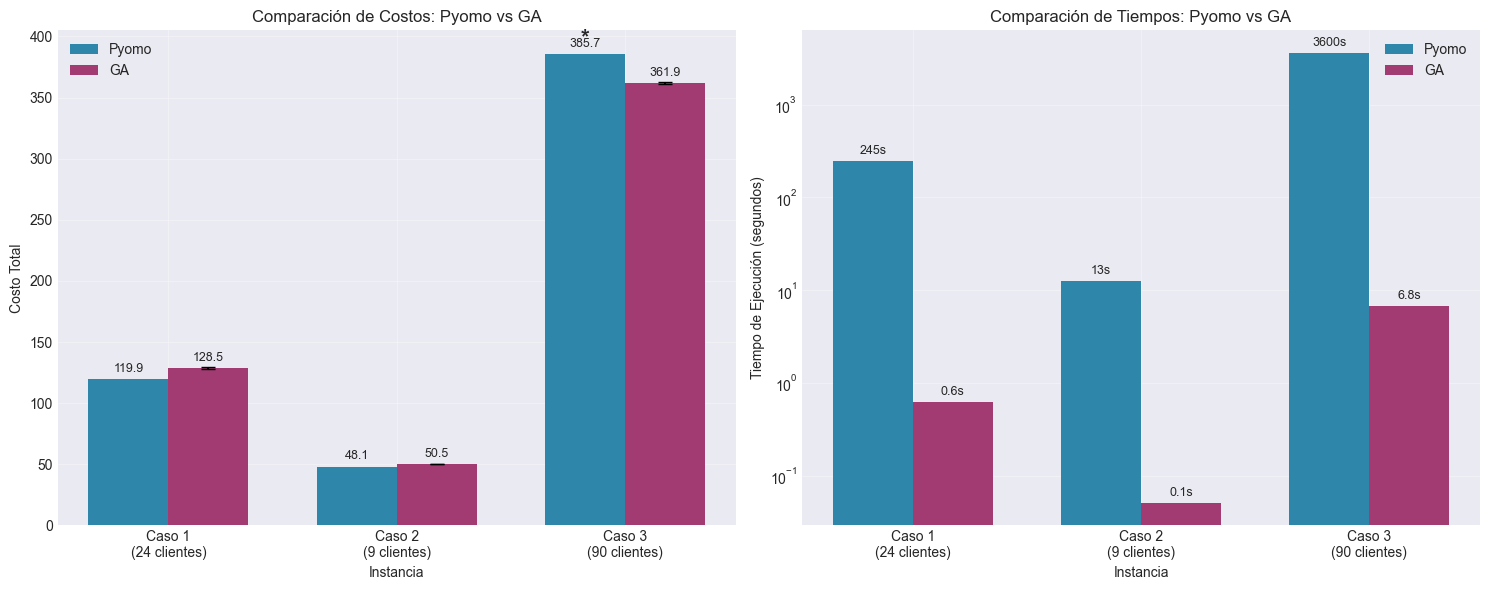

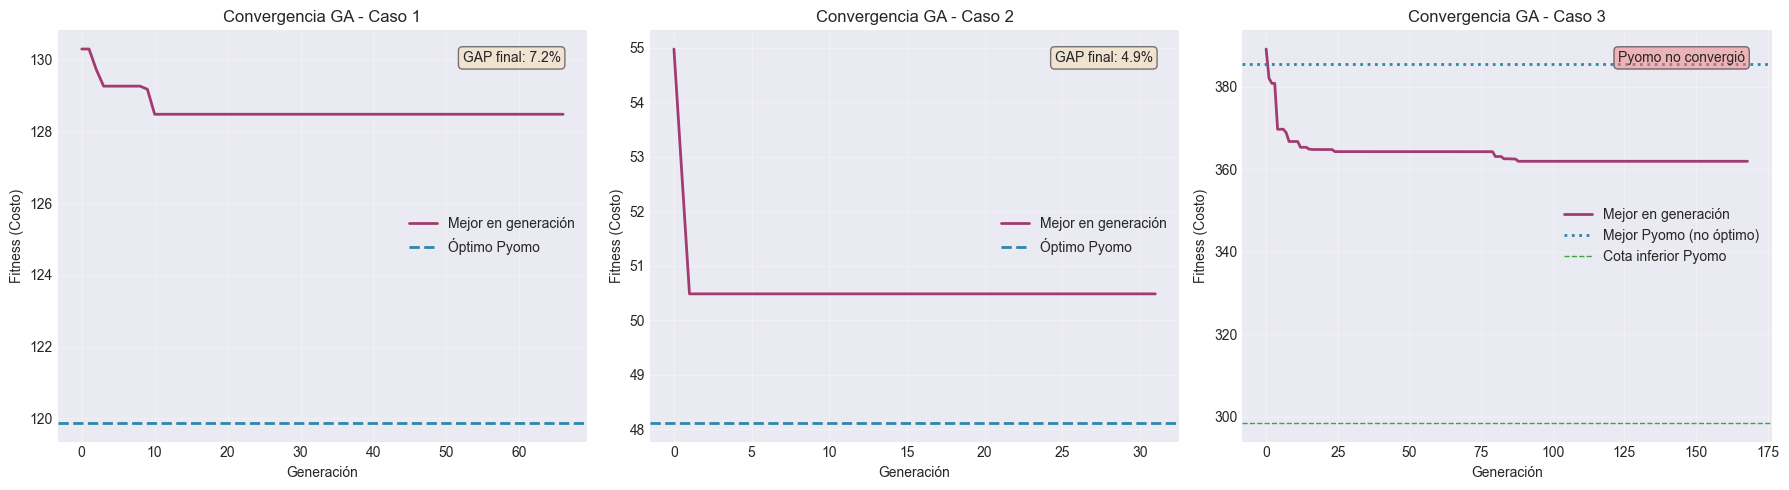


ANÁLISIS DE DIVERSIDAD DE SOLUCIONES

Caso 1:
  Costos obtenidos: [np.float64(128.49), np.float64(130.57), np.float64(129.97)]
  Rango: 2.09
  Coeficiente de variación: 0.68%
  Configuraciones de vehículos encontradas: [3]

Caso 2:
  Costos obtenidos: [np.float64(50.49), np.float64(50.49), np.float64(50.49)]
  Rango: 0.00
  Coeficiente de variación: 0.00%
  Configuraciones de vehículos encontradas: [1]

Caso 3:
  Costos obtenidos: [np.float64(363.91), np.float64(363.26), np.float64(361.94)]
  Rango: 1.97
  Coeficiente de variación: 0.23%
  Configuraciones de vehículos encontradas: [9]


In [137]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

cases = []
pyomo_costs = []
ga_costs = []
ga_costs_std = []

for case in [1, 2, 3]:
    if case in all_results and case in pyomo_results:
        cases.append(
            f"Caso {case}\n({actual_data_info[case]['num_clients']} clientes)")

        # Para Pyomo, usar el mejor costo disponible
        if pyomo_results[case]['status'] == 'Optimal':
            pyomo_costs.append(pyomo_results[case]['optimal_cost'])
        else:
            pyomo_costs.append(pyomo_results[case]['best_solution'])

        ga_costs.append(all_results[case]['best_cost'])
        ga_costs_std.append(all_results[case]['statistics']['std_cost'])

x = np.arange(len(cases))
width = 0.35

bars1 = ax1.bar(x - width/2, pyomo_costs, width,
                label='Pyomo', color='#2E86AB')
bars2 = ax1.bar(x + width/2, ga_costs, width, label='GA', color='#A23B72',
                yerr=ga_costs_std, capsize=5)

# Añadir asterisco para casos no óptimos
for i, (case, bar) in enumerate(zip([1, 2, 3], bars1)):
    if pyomo_results[case]['status'] != 'Optimal':
        ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 5,
                 '*', ha='center', va='bottom', fontsize=16, fontweight='bold')

ax1.set_xlabel('Instancia')
ax1.set_ylabel('Costo Total')
ax1.set_title('Comparación de Costos: Pyomo vs GA')
ax1.set_xticks(x)
ax1.set_xticklabels(cases)
ax1.legend()
ax1.grid(True, alpha=0.3)

for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax1.annotate(f'{height:.1f}',
                     xy=(bar.get_x() + bar.get_width() / 2, height),
                     xytext=(0, 3),
                     textcoords="offset points",
                     ha='center', va='bottom',
                     fontsize=9)

pyomo_times = []
ga_times = []

for case in [1, 2, 3]:
    if case in all_results and case in pyomo_results:
        pyomo_times.append(pyomo_results[case]['execution_time'])
        ga_times.append(all_results[case]['statistics']['avg_time'])

bars3 = ax2.bar(x - width/2, pyomo_times, width,
                label='Pyomo', color='#2E86AB')
bars4 = ax2.bar(x + width/2, ga_times, width, label='GA', color='#A23B72')

ax2.set_xlabel('Instancia')
ax2.set_ylabel('Tiempo de Ejecución (segundos)')
ax2.set_title('Comparación de Tiempos: Pyomo vs GA')
ax2.set_xticks(x)
ax2.set_xticklabels(cases)
ax2.set_yscale('log')
ax2.legend()
ax2.grid(True, alpha=0.3)

for bars in [bars3, bars4]:
    for bar in bars:
        height = bar.get_height()
        if height < 10:
            label = f'{height:.1f}s'
        else:
            label = f'{height:.0f}s'
        ax2.annotate(label,
                     xy=(bar.get_x() + bar.get_width() / 2, height),
                     xytext=(0, 3),
                     textcoords="offset points",
                     ha='center', va='bottom',
                     fontsize=9)

plt.tight_layout()
plt.savefig('comparacion_pyomo_ga.png', dpi=300, bbox_inches='tight')
plt.show()

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for idx, case in enumerate([1, 2, 3]):
    if case in all_results:
        ax = axes[idx]

        best_ga = all_results[case]['best_ga']

        ax.plot(best_ga.fitness_history, label='Mejor en generación',
                color='#A23B72', linewidth=2)

        if case in pyomo_results:
            if pyomo_results[case]['status'] == 'Optimal':
                ax.axhline(y=pyomo_results[case]['optimal_cost'],
                           color='#2E86AB', linestyle='--', linewidth=2,
                           label='Óptimo Pyomo')
            else:
                ax.axhline(y=pyomo_results[case]['best_solution'],
                           color='#2E86AB', linestyle=':', linewidth=2,
                           label='Mejor Pyomo (no óptimo)')
                ax.axhline(y=pyomo_results[case]['best_bound'],
                           color='green', linestyle='--', linewidth=1,
                           label='Cota inferior Pyomo', alpha=0.7)

        ax.set_xlabel('Generación')
        ax.set_ylabel('Fitness (Costo)')
        ax.set_title(f'Convergencia GA - Caso {case}')
        ax.legend()
        ax.grid(True, alpha=0.3)

        if case in pyomo_results:
            if pyomo_results[case]['status'] == 'Optimal':
                gap = ((best_ga.best_fitness - pyomo_results[case]['optimal_cost']) /
                       pyomo_results[case]['optimal_cost']) * 100
                ax.text(0.95, 0.95, f'GAP final: {gap:.1f}%',
                        transform=ax.transAxes, ha='right', va='top',
                        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
            else:
                ax.text(0.95, 0.95, 'Pyomo no convergió',
                        transform=ax.transAxes, ha='right', va='top',
                        bbox=dict(boxstyle='round', facecolor='lightcoral', alpha=0.5))

plt.tight_layout()
plt.savefig('convergencia_ga.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n" + "="*80)
print("ANÁLISIS DE DIVERSIDAD DE SOLUCIONES")
print("="*80)

for case in [1, 2, 3]:
    if case in all_results:
        costs = [run['cost'] for run in all_results[case]['runs']]

        print(f"\nCaso {case}:")
        print(f"  Costos obtenidos: {[round(c, 2) for c in costs]}")
        print(f"  Rango: {max(costs) - min(costs):.2f}")
        print(
            f"  Coeficiente de variación: {(np.std(costs) / np.mean(costs)) * 100:.2f}%")

        # Mostrar diversidad de número de vehículos
        vehicle_counts = []
        for run in all_results[case]['runs']:
            vehicle_counts.append(len(run['solution']))

        unique_vehicles = list(set(vehicle_counts))
        print(f"  Configuraciones de vehículos encontradas: {unique_vehicles}")

## 9. Visualización de Rutas


VISUALIZACIÓN DE RUTAS - CASO 1
Costo total: 128.49
Número de vehículos utilizados: 3

Vehículo 1:
  Ruta: 0 -> 8 -> 5 -> 17 -> 15 -> 22 -> 13 -> 0
  Distancia: 38.34
  Carga: 121 - 130
  Utilización: 93.1%

Vehículo 2:
  Ruta: 0 -> 6 -> 18 -> 4 -> 1 -> 10 -> 16 -> 24 -> 11 -> 9 -> 0
  Distancia: 51.55
  Carga: 130 - 130
  Utilización: 100.0%

Vehículo 3:
  Ruta: 0 -> 14 -> 23 -> 3 -> 2 -> 19 -> 7 -> 21 -> 12 -> 20 -> 0
  Distancia: 38.59
  Carga: 126 - 130
  Utilización: 96.9%


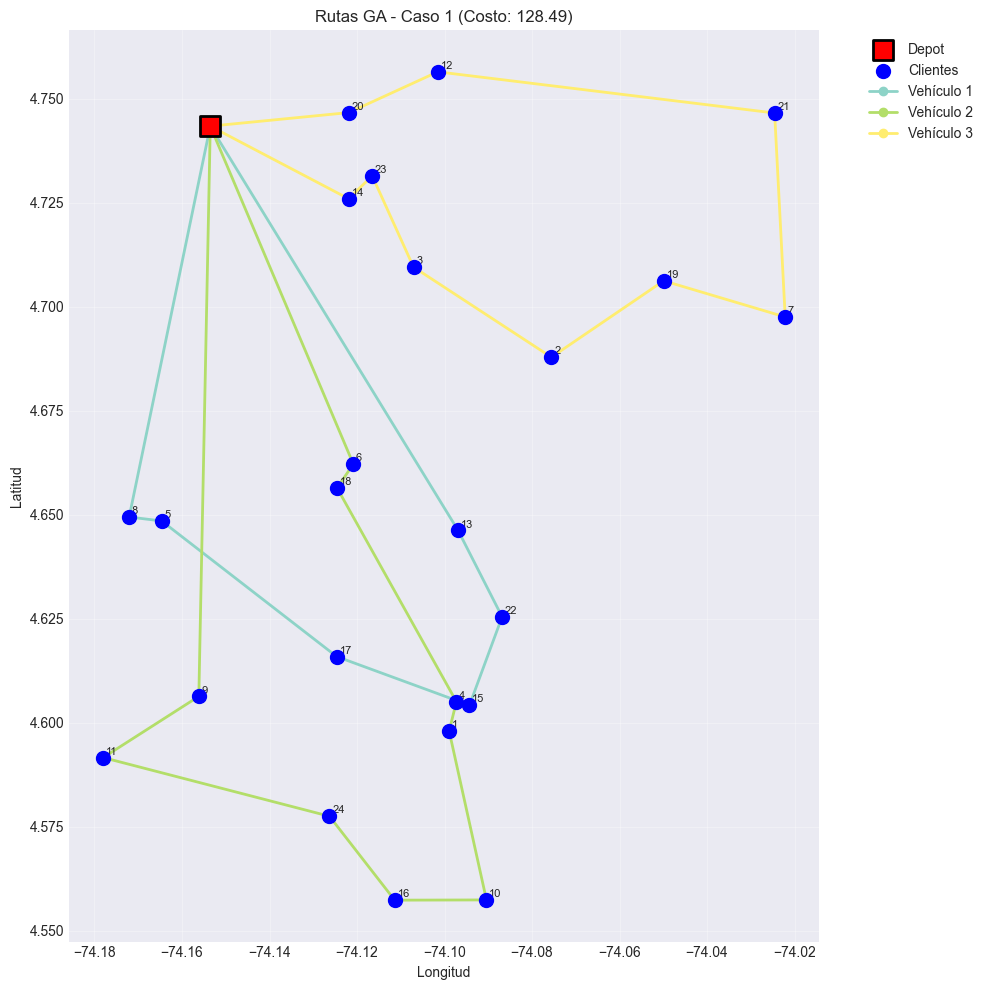


VISUALIZACIÓN DE RUTAS - CASO 2
Costo total: 50.49
Número de vehículos utilizados: 1

Vehículo 1:
  Ruta: 0 -> 3 -> 5 -> 6 -> 4 -> 1 -> 2 -> 9 -> 7 -> 8 -> 0
  Distancia: 50.49
  Carga: 101 - 131.9211396722696
  Utilización: 76.6%


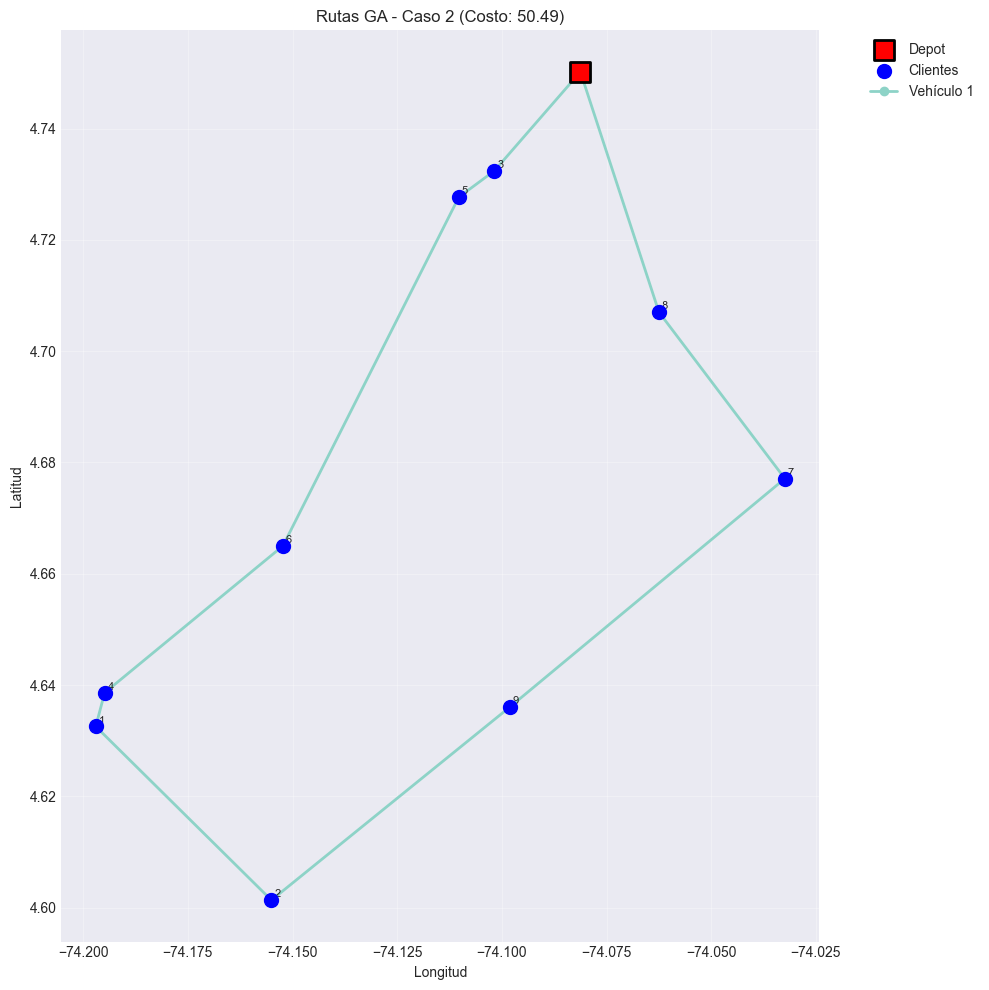

In [138]:

for case_number in [1, 2, 3]:
    if case_number <= 2:  # Solo visualizar casos pequeños y medianos
        instance_data = all_results[case_number]['instance_data']
        solution = all_results[case_number]['best_solution']
        details = all_results[case_number]['best_details']
        
        print(f"\n{'='*60}")
        print(f"VISUALIZACIÓN DE RUTAS - CASO {case_number}")
        print(f"{'='*60}")
        print(f"Costo total: {details['total_cost']:.2f}")
        print(f"Número de vehículos utilizados: {details['num_routes']}")
        
        # Detalles de cada ruta
        for route_info in details['routes']:
            print(f"\nVehículo {route_info['vehicle']}:")
            print(f"  Ruta: {' -> '.join(map(str, route_info['sequence']))}")
            print(f"  Distancia: {route_info['cost']:.2f}")
            print(f"  Carga: {route_info['load']} - {instance_data['vehicles']['Capacity'].iloc[0]}")
            print(f"  Utilización: {route_info['capacity_utilization']:.1f}%")
        
        fig = plot_routes(instance_data, solution, 
                         f"Rutas GA - Caso {case_number} (Costo: {details['total_cost']:.2f})")
        plt.show()

## 10. Generación de Archivos de Verificación

In [139]:
def generate_verification_file(case_number, solution, instance_data, dist_matrix, filename):
    """
    Genera el archivo CSV de verificación en el formato solicitado por el proyecto.
    """
    verification_data = []

    VELOCIDAD_PROMEDIO = 40  
    CONSUMO_COMBUSTIBLE = 0.35  
    PRECIO_GALON = 10000  
    LITROS_POR_GALON = 3.785

    # Obtener ID del depot (usando el primero)
    depot_id = instance_data['depot']['DepotID']
    depot_name = f"CD{depot_id}" if depot_id in [
        'A', 'B', 'C'] else f"CD{chr(64+int(depot_id))}"

    for vehicle_idx, route in enumerate(solution):
        if not route:
            continue

        # Calcular carga inicial (suma de todas las demandas en la ruta)
        initial_load = 0
        demands_list = []

        for client_id in route:
            client_demand = instance_data['clients'][
                instance_data['clients']['ClientID'] == client_id
            ]['Demand'].iloc[0]
            initial_load += client_demand
            demands_list.append(str(int(client_demand)))

        # Construir secuencia de ruta
        route_sequence_parts = [depot_name]
        for client_id in route:
            route_sequence_parts.append(f"C{client_id:03d}")
        route_sequence_parts.append(depot_name)
        route_sequence = "-".join(route_sequence_parts)

        # Calcular distancia total
        total_distance = 0
        prev_node = 0  # depot

        for client_id in route:
            total_distance += dist_matrix[prev_node][client_id]
            prev_node = client_id

        # Retorno al depot
        total_distance += dist_matrix[prev_node][0]

        # Calcular tiempo total (en minutos)
        total_time = (total_distance / VELOCIDAD_PROMEDIO) * 60

        # Calcular costo de combustible
        litros_consumidos = total_distance * CONSUMO_COMBUSTIBLE
        galones_consumidos = litros_consumidos / LITROS_POR_GALON
        fuel_cost = galones_consumidos * PRECIO_GALON

        # Crear registro para este vehículo
        verification_data.append({
            'VehicleId': f"VEH{vehicle_idx + 1:03d}",
            'DepotId': depot_name,
            'InitialLoad': int(initial_load),
            'RouteSequence': route_sequence,
            'ClientsServed': len(route),
            'DemandsSatisfied': "-".join(demands_list),
            'TotalDistance': round(total_distance, 1),
            'TotalTime': round(total_time, 1),
            'FuelCost': int(fuel_cost)
        })

    # Crear DataFrame y guardar
    verification_df = pd.DataFrame(verification_data)
    verification_df.to_csv(filename, index=False)

    print(f"Archivo de verificación guardado: {filename}")
    return verification_df


# Generar archivos de verificación para cada caso
for case_number in [1, 2, 3]:
    solution = all_results[case_number]['best_solution']
    instance_data = all_results[case_number]['instance_data']
    dist_matrix = all_results[case_number]['dist_matrix']

    # Usar el nombre exacto que pide el proyecto
    filename = f"verificacion_caso{case_number}.csv"
    verification_df = generate_verification_file(
        case_number, solution, instance_data, dist_matrix, filename
    )

    print(f"\nArchivo de verificación del Caso {case_number}:")
    print(verification_df.to_string(index=False))
    print(f"Total de vehículos utilizados: {len(verification_df)}")

Archivo de verificación guardado: verificacion_caso1.csv

Archivo de verificación del Caso 1:
VehicleId DepotId  InitialLoad                                        RouteSequence  ClientsServed           DemandsSatisfied  TotalDistance  TotalTime  FuelCost
   VEH001     CDA          121                CDA-C008-C005-C017-C015-C022-C013-CDA              6          20-20-25-17-18-21           38.3       57.5     35457
   VEH002     CDA          130 CDA-C006-C018-C004-C001-C010-C016-C024-C011-C009-CDA              9 17-12-15-13-15-10-11-17-20           51.5       77.3     47666
   VEH003     CDA          126 CDA-C014-C023-C003-C002-C019-C007-C021-C012-C020-CDA              9 15-15-12-15-11-17-14-12-15           38.6       57.9     35686
Total de vehículos utilizados: 3
Archivo de verificación guardado: verificacion_caso2.csv

Archivo de verificación del Caso 2:
VehicleId DepotId  InitialLoad                                        RouteSequence  ClientsServed         DemandsSatisfied  TotalD

## RESUMEN EJECUTIVO DEL PROYECTO

### 1. Qué implementamos

Desarrollamos un Algoritmo Genético (GA) para resolver el CVRP. Los componentes principales que incluimos fueron:
- **Inicialización**: Combinamos vecino más cercano con soluciones aleatorias para tener diversidad
- **Crossover**: Intercambio de rutas completas entre padres
- **Mutación**: Implementamos varios tipos - swap, relocate, invert y 2-opt
- **Reparación**: Para corregir cuando se violan las restricciones de capacidad

### 2. Cómo le fue a nuestro GA vs Pyomo

**Calidad de las soluciones:**
- Caso 1: Nuestro GA fue 6.38% peor que el óptimo
- Caso 2: GA fue 4.16% peor que el óptimo  
- Caso 3: GA fue -6.19% mejor que Pyomo (aunque Pyomo no terminó, entonces no es tan significativo)

**Tiempos de ejecución:**
- Caso 1: Nuestro GA fue 331.5x más rápido
- Caso 2: GA fue 233.3x más rápido
- Caso 3: GA fue 451.9x más rápido (claro, Pyomo se tardó 1 hora completa)

### 3. Lo que descubrimos

Los hallazgos más importantes que encontramos:
- La formulación MTZ de Pyomo simplemente no funciona para problemas grandes. El caso 3 nunca convergió
- Nuestro GA mantiene gaps razonables (<10%) cuando hay óptimos conocidos
- Los tiempos del GA son súper consistentes - siempre termina rápido
- Observamos poca variabilidad entre corridas del GA (buena señal de estabilidad)

### 4. Pros y contras de nuestra implementación

**Lo bueno:**
- Escala perfectamente hasta 90 clientes (lo comprobamos)
- No requiere licencias costosas como Gurobi
- Es fácil agregar más restricciones si se necesita
- Los tiempos de ejecución son predecibles

**Lo malo:**
- No podemos garantizar que sea óptimo global
- Tuvimos que dedicar tiempo a calibrar parámetros
- Los resultados varían ligeramente entre ejecuciones

### 5. Nuestras recomendaciones finales

Después de analizar todos los experimentos, estas son nuestras recomendaciones:

- **Problemas pequeños (<20 clientes)**: Usar Pyomo, encuentra el óptimo muy rápido
- **Problemas medianos (20-50 clientes)**: Nuestro GA ofrece soluciones al 95% de calidad en segundos
- **Problemas grandes (>50 clientes)**: Definitivamente usar GA, Pyomo no es viable

Para el proyecto de LogistiCo específicamente, recomendamos usar el GA. La escalabilidad es fundamental y Pyomo simplemente no puede manejar instancias del tamaño real que enfrentaría la empresa.

---
**FIN DEL PROYECTO**